# **Segmentación de clientes**

El set de datos proporcionado tiene caracteristicas muy interesantes para aplicar tecnicas de segmentación de usuarios empleando RFM. Este es un tipo de segmentación de clientes y orientación por comportamiento que se utiliza para ayudar a las empresas a clasificar y segmentar a los clientes en función de la recencia, la frecuencia y el valor monetario de una transacción.

## Importar librerias

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.cm as cm
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

import sklearn
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings("ignore")

## Leer la data

In [3]:
df = pd.read_csv('/content/process_online_retail_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
# Solo interesan los usuarios que tienen id.
df = df[df['customerid'] != 0]
df['invoicedate'] = pd.to_datetime(df['invoicedate'])
df.head()


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,total_pay,hour,day,weekday,month,year
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,united kingdom,15.30,8.0,1.0,2.0,12.0,2010.0
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,united kingdom,20.34,8.0,1.0,2.0,12.0,2010.0
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,united kingdom,22.00,8.0,1.0,2.0,12.0,2010.0
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,united kingdom,20.34,8.0,1.0,2.0,12.0,2010.0
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,united kingdom,20.34,8.0,1.0,2.0,12.0,2010.0


## Calcular Recency

Recency se refiere a la medida del tiempo transcurrido desde la última compra o interacción de un cliente con la empresa. Es una métrica importante, ya que los clientes que han realizado compras más recientemente tienden a tener un mayor grado de compromiso con la marca y, por lo general, son más valiosos para la empresa. Los clientes más recientes pueden ser objetivos para promociones o campañas de retención, ya que es más probable que estén dispuestos a realizar otra compra.

In [4]:
df_recency = df.groupby(by='customerid', as_index=False)['invoicedate'].max()
df_recency.columns = ['customerid', 'lastinvoicedate']
recent_date = df_recency['lastinvoicedate'].max()
df_recency['Recency'] = df_recency['lastinvoicedate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,customerid,lastinvoicedate,Recency
0,12346.0,2011-01-18 10:17:00,321
1,12347.0,2011-10-31 12:25:00,35
2,12348.0,2011-09-25 13:13:00,71
3,12349.0,2011-11-21 09:51:00,14
4,12350.0,2011-02-02 16:01:00,306


## Calcular Frequency

La Frecuencia se refiere a la cantidad de veces que un cliente ha realizado compras o interacciones con la empresa durante un período específico. Esta métrica permite identificar qué tan leal es un cliente y cuántas veces regresa para realizar más compras. Los clientes con una alta frecuencia de compras son más propensos a ser leales y pueden ser un objetivo importante para programas de fidelización y recompensas.

In [5]:
frequency_df = df.drop_duplicates().groupby(by=['customerid'], as_index=False)['invoicedate'].count()
frequency_df.columns = ['customerid', 'Frequency']
frequency_df.head()

,customerid,Frequency
0,12346.0,2
1,12347.0,171
2,12348.0,31
3,12349.0,73
4,12350.0,17


## Calculating Monetary Value

l Valor Monetario se refiere al total del valor monetario de las compras realizadas por un cliente durante un período específico. Esta métrica mide el gasto total del cliente en productos o servicios de la empresa. Los clientes con un alto valor monetario son aquellos que gastan más dinero en cada compra, lo que los convierte en clientes de alto valor para la empresa. Estos clientes pueden ser objetivos para ofertas especiales, ventas cruzadas y programas VIP.

In [6]:
monetary_df = df.groupby(by='customerid', as_index=False)['total_pay'].sum()
monetary_df.columns = ['customerid', 'Monetary']
monetary_df.head()

,customerid,Monetary
0,12346.0,154367.20
1,12347.0,4085.18
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


## **Crear el dataframe RFM**

In [7]:
rf_df = df_recency.merge(frequency_df, on='customerid')
rfm_df = rf_df.merge(monetary_df, on='customerid').drop(columns='lastinvoicedate')
rfm_kmeans = rfm_df.copy()
rfm_df.head()

,customerid,Recency,Frequency,Monetary
0,12346.0,321,2,154367.20
1,12347.0,35,171,4085.18
2,12348.0,71,31,1797.24
3,12349.0,14,73,1757.55
4,12350.0,306,17,334.40


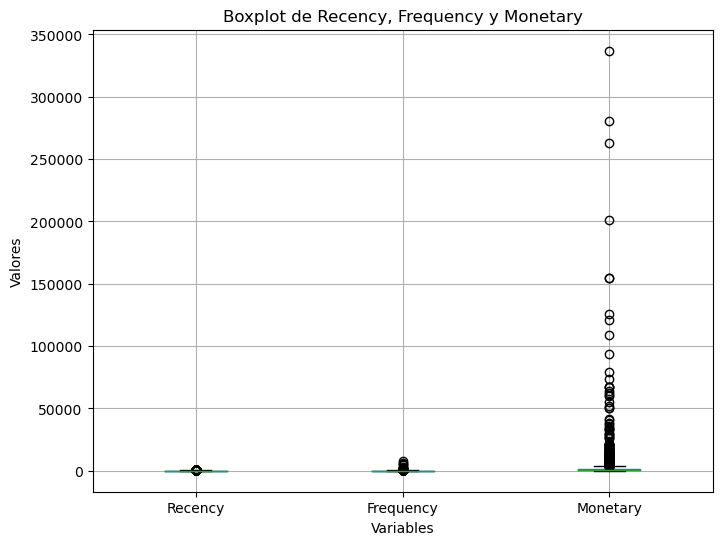

In [ ]:
plt.figure(figsize=(8, 6))
rfm_df[['Recency', 'Frequency', 'Monetary']].boxplot()
plt.title('Boxplot de Recency, Frequency y Monetary')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.show()

## Ranking a los clientes segun RFM

Clasificar a los clientes según sus puntuaciones de recencia, frecuencia y valor monetario (RFM) para identificar y priorizar los grupos de clientes más valiosos o con mayor potencial de crecimiento



In [10]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

#Normalizar el rank de los clientes
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_df.head()

,customerid,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,321,2,154367.20,3.980447,2.516085,2.516085
1,12347.0,35,171,4085.18,57.821229,87.396599,87.396599
2,12348.0,71,31,1797.24,39.187616,42.451746,42.451746
3,12349.0,14,73,1757.55,77.688547,67.038143,67.038143
4,12350.0,306,17,334.40,5.609870,25.011489,25.011489


## Calcular RFM score

* **Recency Score:** Se asigna una puntuación a cada cliente basada en la recencia de su última compra o interacción. Por ejemplo, los clientes que han realizado una compra más recientemente pueden recibir una puntuación más alta, mientras que aquellos cuya última compra fue hace mucho tiempo pueden recibir una puntuación más baja.

* **Frequency Score:** Se asigna una puntuación a cada cliente según la frecuencia con la que han realizado compras o interactuado con la empresa durante un período determinado. Los clientes que han realizado más compras obtienen una puntuación más alta, mientras que aquellos con menos compras reciben una puntuación más baja.

* **Monetary Score:** Se asigna una puntuación a cada cliente en función del valor monetario total de sus compras. Los clientes que han gastado más dinero en sus compras obtienen una puntuación más alta, mientras que aquellos que han gastado menos reciben una puntuación más baja.


La formula usada en este caso es: ```0.15 * Recency score + 0.28 * Frequency score + 0.57 * Monetary score```

In [17]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+ 0.28 * rfm_df['F_rank_norm'] + 0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['customerid', 'RFM_Score']].head(7)

,customerid,RFM_Score
0,12346.0,0.14
1,12347.0,4.15
2,12348.0,2.10
3,12349.0,3.43
4,12350.0,1.11
5,12352.0,3.58
6,12353.0,0.34


## Rating a los clientes basados en el RFM score

En este caso agrupos a los usuarios por puntajes estandar para esta clasificacion, pero segun el negocio estos se pueden ajustar. Se debe tener un conocimiento profundo en las necesidades del negocio


- rfm score >4.5 : Top Customer
- 4.5 > rfm score > 4 : High Value Customer
- 4>rfm score >3 : Medium value customer
- 3>rfm score>1.6 : Low-value customer
- rfm score<1.6 :Lost Customer

In [19]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >4.5, "Top Customers",
                             (np.where(rfm_df['RFM_Score'] > 4,"High value Customer",
                             (np.where(rfm_df['RFM_Score'] > 3, "Medium Value Customer",
                              np.where(rfm_df['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))))
rfm_df[['customerid', 'RFM_Score', 'Customer_segment']].head(20)

,customerid,RFM_Score,Customer_segment
0,12346.0,0.14,Lost Customers
1,12347.0,4.15,High value Customer
2,12348.0,2.10,Low Value Customers
3,12349.0,3.43,Medium Value Customer
4,12350.0,1.11,Lost Customers
5,12352.0,3.58,Medium Value Customer
6,12353.0,0.34,Lost Customers
7,12354.0,2.68,Low Value Customers
8,12355.0,0.94,Lost Customers
9,12356.0,3.14,Medium Value Customer


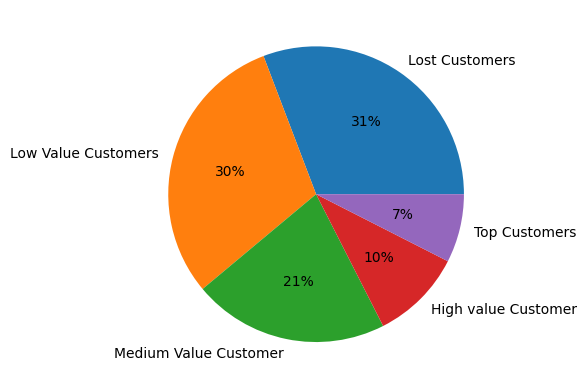

In [20]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

Esta es una primera clasificacion que permite al negocio clasificar a los usuarios en funcion de su comportamiento transaccional. El negocio tendra datos para tomar acciones y estrategias de retencion, fidelizacion o recuperacion de clientes agregando un analisis de categorias de productos que complementen la informacion

## K-Means para RFM

K-means es un algoritmo de aprendizaje no supervisado para agrupamiento utilizado para separar un conjunto de datos en grupos o clústeres homogéneos. En el contexto del análisis RFM (Recency, Frequency, Monetary), K-means se puede utilizar para agrupar a los clientes en segmentos basados en sus puntuaciones de recencia, frecuencia y valor monetario.



El primer paso es la estandarización/normalización de la data, en este caso, se realizo con el metodo StandarScaler.

StandarScaler implica restar la media (centrar los datos) y dividir por la desviación estándar de cada variable, lo que da como resultado una distribución con una media de cero y una desviación estándar de uno

Este escalamiento permite asegurar que todas las variables tengan la misma importancia y que el algoritmo funcione de manera óptima

In [21]:
scaler = StandardScaler()
rfm_normalized = rfm_kmeans[['Monetary', 'Frequency', 'Recency']]
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized.columns=['Monetary', 'Frequency', 'Recency']
rfm_normalized

,Monetary,Frequency,Recency
0,16.946406,-0.395343,2.295970
1,0.225130,0.360096,-0.558822
2,-0.029440,-0.265711,-0.199478
3,-0.033856,-0.077969,-0.768440
4,-0.192204,-0.328292,2.146243
...,...,...,...
4347,-0.209317,-0.359583,1.816844
4348,-0.220419,-0.372993,0.848610
4349,-0.209439,-0.346172,-0.878239
4350,-0.024957,2.595124,-0.858276


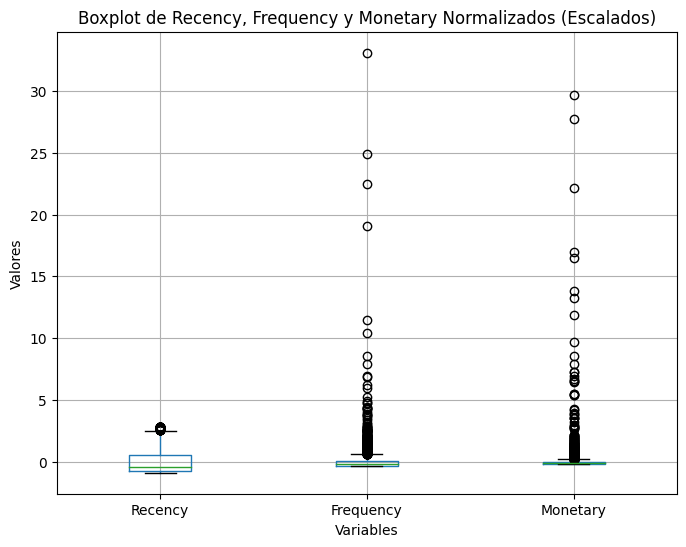

In [30]:
plt.figure(figsize=(8, 6))
rfm_normalized[['Recency', 'Frequency', 'Monetary']].boxplot()
plt.title('Boxplot de Recency, Frequency y Monetary Normalizados (Escalados)')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.show()

In [23]:
rfm_normalized

,Monetary,Frequency,Recency
0,16.946406,-0.395343,2.295970
1,0.225130,0.360096,-0.558822
2,-0.029440,-0.265711,-0.199478
3,-0.033856,-0.077969,-0.768440
4,-0.192204,-0.328292,2.146243
...,...,...,...
4347,-0.209317,-0.359583,1.816844
4348,-0.220419,-0.372993,0.848610
4349,-0.209439,-0.346172,-0.878239
4350,-0.024957,2.595124,-0.858276


## Kmeans

In [24]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_normalized)

KMeans(max_iter=50, n_clusters=4)

### K means y el coeficiente de silueta (Silhouette Analysis)

El coeficiente de silueta es la metrica de evaluación del aprendizaje no supervisado.

El coeficiente de silueta tiene un rango de valores de [-1,1]. Siendo
* 1: Perfecto, esta totalmente separado de los demás clústeres
* 0: No esta de la mejor manera clasificado, pero se encuentra bien separado en su cluster
* -n : Definitivamente no pertenece al cluster que deberia estar.

En este caso realizo una evaluacion de parametros para saber con cuales tengo una buena metrica de evaluación

In [27]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(rfm_normalized)
    kmeanModel.fit(rfm_normalized)
    distortions.append(sum(np.min(cdist(rfm_normalized, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / rfm_normalized.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(rfm_normalized, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / rfm_normalized.shape[0]
    mapping2[k] = kmeanModel.inertia_

    cluster_labels = kmeanModel.labels_

    ##Silhouette score
    silhouette_avg = silhouette_score(rfm_normalized,cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(k, silhouette_avg))

For n_clusters=2, the silhouette score is 0.926039970971245
For n_clusters=3, the silhouette score is 0.6006324296479051
For n_clusters=4, the silhouette score is 0.6008275376731272
For n_clusters=5, the silhouette score is 0.6151580927267287
For n_clusters=6, the silhouette score is 0.5906991933442476
For n_clusters=7, the silhouette score is 0.5312421004192155
For n_clusters=8, the silhouette score is 0.5293478372439943
For n_clusters=9, the silhouette score is 0.4544739442645901


### Elbow Curve

Ahora voy a confirmar los valores de K sugeridos en el coeficiente de la silueta con el metodo de la curva del codo.

Consiste en graficar la inercia o la suma de los errores cuadráticos en el K-means con diferentes K y seleccionar el valor que se encuentre en el codo ( intersección donde baja y se aplana la función)

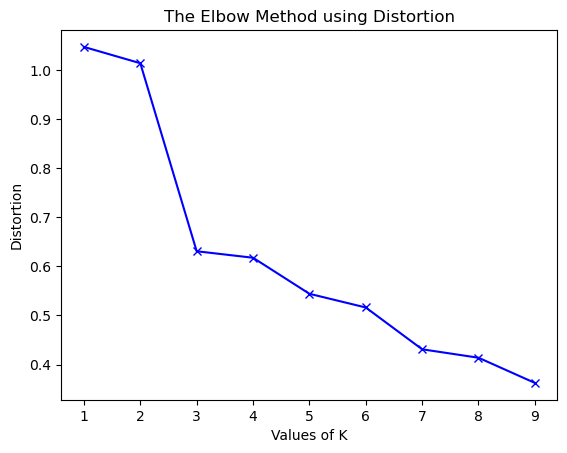

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

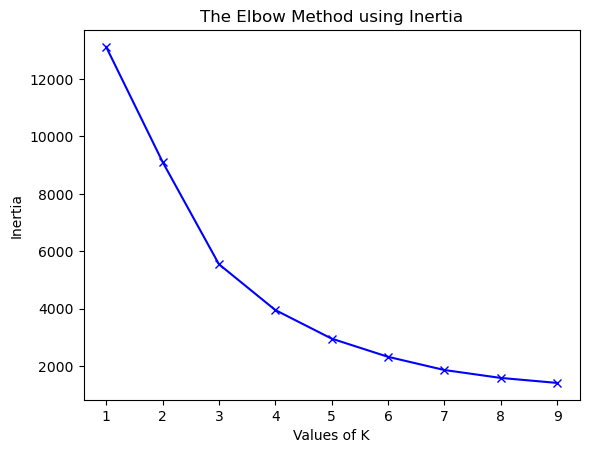

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Finalmente, decidto tomar K=2 y K= 5

## K= 2

In [28]:
k=2
kmeans = KMeans(n_clusters=k,max_iter=50)
kmeans.fit(rfm_normalized)
rfm_normalized.loc[:,'customerid'] = rfm_kmeans['customerid']
rfm_normalized['cluster'] = kmeans.labels_
rfm_kmeans['cluster']= kmeans.labels_

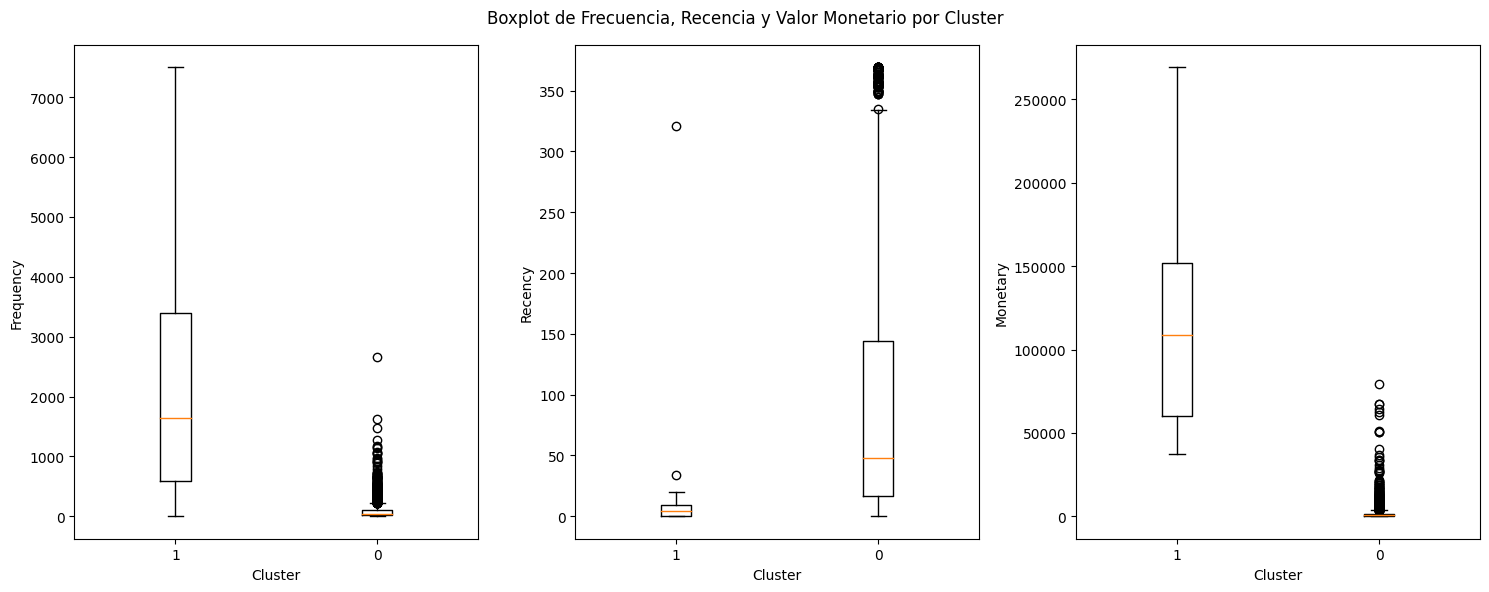

In [35]:
# Lista de los nombres de los clústeres
cluster_names = rfm_kmeans['cluster'].unique()

# Crear una figura para los boxplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Crear los boxplots para cada métrica RFM
for i, metric in enumerate(['Frequency', 'Recency', 'Monetary']):
    # Lista de los datos para cada clúster
    data = [rfm_kmeans[rfm_kmeans['cluster'] == cluster][metric] for cluster in cluster_names]

    # Graficar el boxplot
    axs[i].boxplot(data)
    axs[i].set_xticklabels(cluster_names)
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(metric.capitalize())

plt.suptitle('Boxplot de Frecuencia, Recencia y Valor Monetario por Cluster')
plt.tight_layout()
plt.show()

In [36]:
for i in range(0,k):
    print(rfm_kmeans[rfm_kmeans['cluster'] == i].describe())
    print('_______________________________________________')

         customerid      Recency    Frequency      Monetary  cluster
count   4337.000000  4337.000000  4337.000000   4337.000000   4337.0
mean   15302.950657    91.203597    82.726770   1655.415048      0.0
std     1721.737592   100.189895   127.170235   3931.105350      0.0
min    12347.000000     0.000000     1.000000      0.000000      0.0
25%    13814.000000    17.000000    17.000000    305.190000      0.0
50%    15304.000000    48.000000    40.000000    663.620000      0.0
75%    16781.000000   144.000000    98.000000   1635.660000      0.0
max    18287.000000   369.000000  2661.000000  79183.500000      0.0
_______________________________________________
         customerid     Recency    Frequency       Monetary  cluster
count     15.000000   15.000000    15.000000      15.000000     15.0
mean   14996.600000   27.533333  2321.333333  119569.690667      1.0
std     1995.739276   81.719788  2279.855687   74011.013345      0.0
min    12346.000000    0.000000     2.000000   37322.20

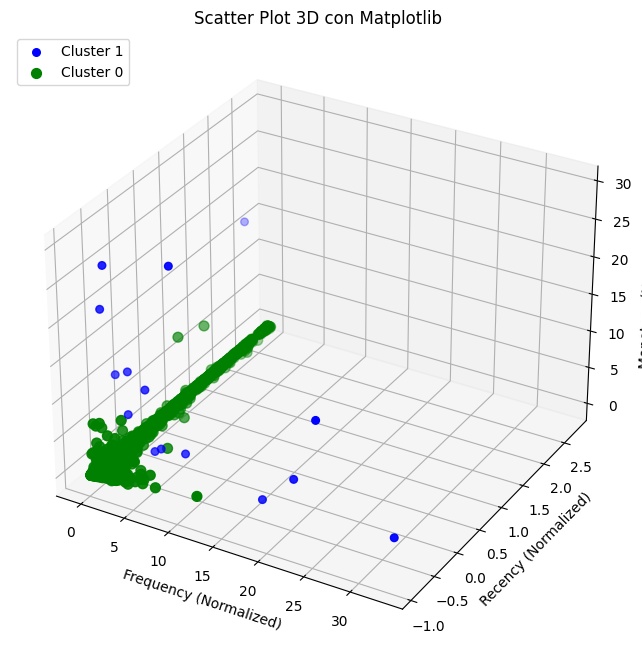

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
sizes = [30, 50, 70, 90, 110, 130, 150, 170, 190, 210]

# Graficar cada punto en el gráfico 3D
for cluster, color, size in zip(rfm_normalized['cluster'].unique(), colors, sizes):
    cluster_data = rfm_normalized[rfm_normalized['cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], cluster_data['Monetary'], c=color, s=size, label=f'Cluster {cluster}')

ax.set_xlabel('Frequency (Normalized)')
ax.set_ylabel('Recency (Normalized)')
ax.set_zlabel('Monetary (Normalized)')
ax.set_title('Scatter Plot 3D con Matplotlib')
ax.legend(loc='upper left')

plt.show()

**Segmento 1 (cluster 0):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 92.38 días   | 0 días | 49 días | 373 días  |
| Frequency     | 88.23 veces  | 1 vez  | 40 veces | 7812 veces|
| Monetary      | 2027.48 und | 1.25 und | 614.015 und | 336942.1 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 92.38 días desde su última compra.
- La frecuencia de compra promedio para este segmento es de aproximadamente 88.23 veces, lo que indica que los clientes compran con regularidad.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2027.48 unidades, aunque existe una gran variabilidad, ya que el máximo gasto alcanza las 336942.1 unidades.

**Segmento 2 (cluster 1):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 89.71 días   | 0 días | 49 días | 373 días  |
| Frequency     | 95.50 veces  | 1 vez  | 42 veces | 5898 veces|
| Monetary      | 2317.01 und | 0 und | 743.23 und | 280923.02 und|

```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 89.71 días desde su última compra, lo que indica una recencia similar al Segmento 0.
- La frecuencia de compra promedio para este segmento es de aproximadamente 95.50 veces, ligeramente mayor que el Segmento 0.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2317.01 unidades, con una mediana de 743.23 unidades. El máximo gasto alcanza las 280923.02 unidades.

**Conclusiones del cluster**
- Ambos segmentos tienen recencias similares, con clientes que han realizado compras recientemente.
- El Segmento 2 muestra una frecuencia de compra ligeramente mayor que el Segmento 1, lo que sugiere que los clientes en el Segmento 2 tienden a comprar con más frecuencia.
- En términos de gasto, el Segmento 2 tiene un gasto promedio mayor que el Segmento 1, con clientes que han gastado más en sus compras.

## K=3

In [41]:
k= 3
kmeans = KMeans(n_clusters=k,max_iter=50)
kmeans.fit(rfm_normalized)
rfm_normalized.loc[:,'customerid'] = rfm_kmeans['customerid']
rfm_normalized['cluster'] = kmeans.labels_
rfm_kmeans['cluster']= kmeans.labels_

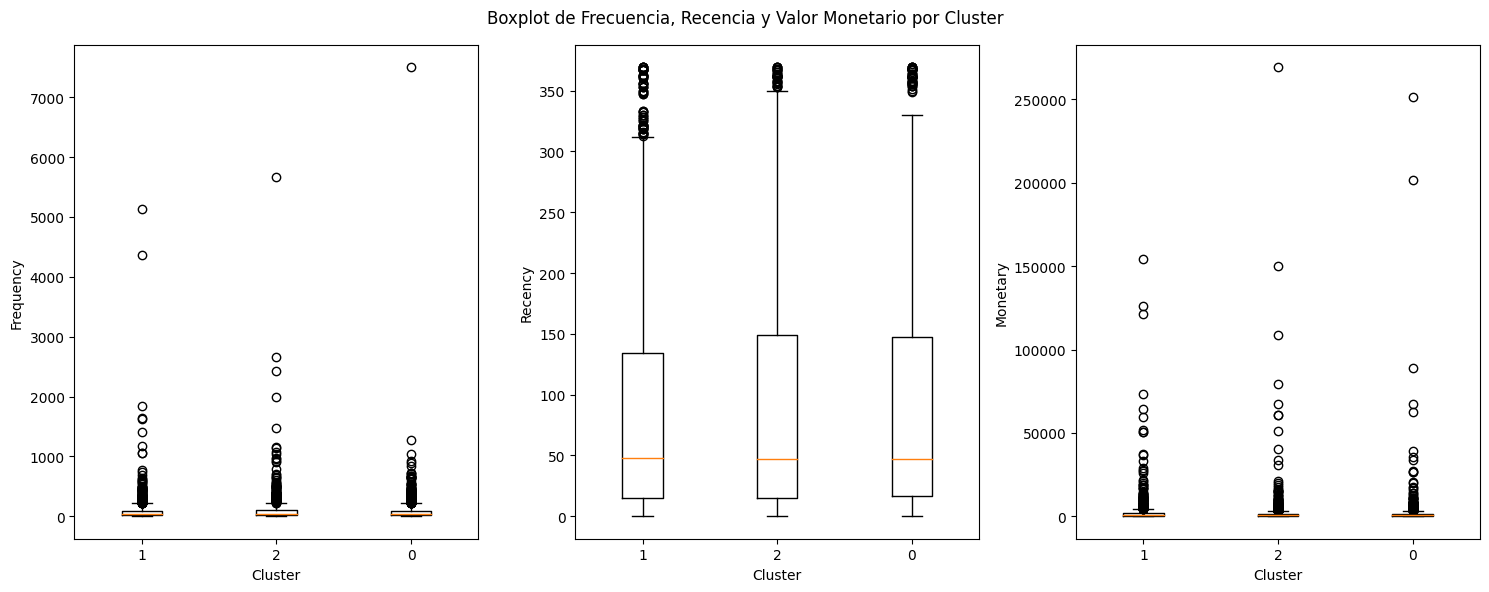

In [42]:
# Lista de los nombres de los clústeres
cluster_names = rfm_kmeans['cluster'].unique()

# Crear una figura para los boxplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Crear los boxplots para cada métrica RFM
for i, metric in enumerate(['Frequency', 'Recency', 'Monetary']):
    # Lista de los datos para cada clúster
    data = [rfm_kmeans[rfm_kmeans['cluster'] == cluster][metric] for cluster in cluster_names]

    # Graficar el boxplot
    axs[i].boxplot(data)
    axs[i].set_xticklabels(cluster_names)
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(metric.capitalize())

plt.suptitle('Boxplot de Frecuencia, Recencia y Valor Monetario por Cluster')
plt.tight_layout()
plt.show()

In [43]:
for i in range(0,k):
    print(rfm_kmeans[rfm_kmeans['cluster'] == i].describe())
    print('_______________________________________________')


         customerid      Recency    Frequency       Monetary  cluster
count   1446.000000  1446.000000  1446.000000    1446.000000   1446.0
mean   17292.944675    91.944675    88.854772    1861.318140      0.0
std      576.554311   100.867317   229.775373    9455.706501      0.0
min    16302.000000     0.000000     1.000000       1.250000      0.0
25%    16789.250000    17.000000    16.000000     261.975000      0.0
50%    17301.500000    47.000000    39.000000     580.640000      0.0
75%    17787.750000   147.750000    97.000000    1514.875000      0.0
max    18287.000000   369.000000  7498.000000  251390.570000      0.0
_______________________________________________
         customerid      Recency    Frequency       Monetary  cluster
count   1448.000000  1448.000000  1448.000000    1448.000000   1448.0
mean   13309.968232    89.540055    89.574586    2327.113903      1.0
std      573.739097    99.514050   220.991755    7775.855315      0.0
min    12346.000000     0.000000     1.000

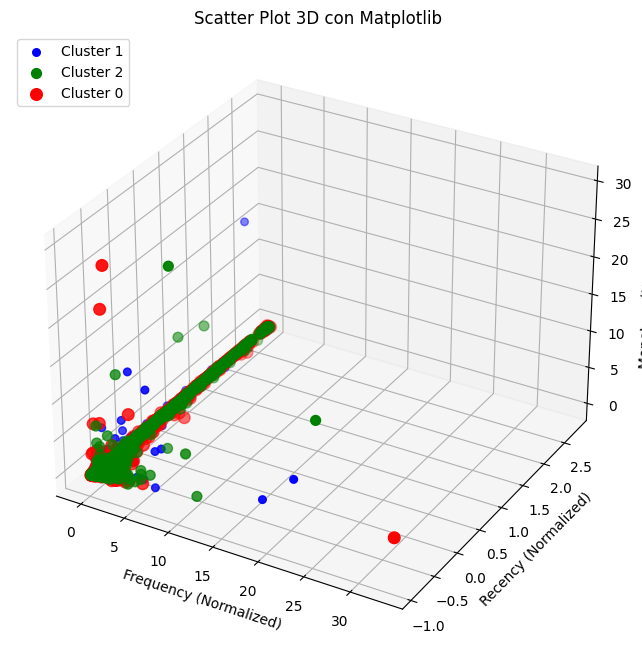

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
sizes = [30, 50, 70, 90, 110, 130, 150, 170, 190, 210]

# Graficar cada punto en el gráfico 3D
for cluster, color, size in zip(rfm_normalized['cluster'].unique(), colors, sizes):
    cluster_data = rfm_normalized[rfm_normalized['cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], cluster_data['Monetary'], c=color, s=size, label=f'Cluster {cluster}')

ax.set_xlabel('Frequency (Normalized)')
ax.set_ylabel('Recency (Normalized)')
ax.set_zlabel('Monetary (Normalized)')
ax.set_title('Scatter Plot 3D con Matplotlib')
ax.legend(loc='upper left')

plt.show()

**Segmento 1 (cluster 0):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 89.85 días   | 0 días | 50 días | 373 días  |
| Frequency     | 90.77 veces  | 1 vez  | 41 veces | 5128 veces|
| Monetary      | 2351.99 und | 0 und | 788.14 und | 154367.2 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 89.85 días desde su última compra, lo que indica que también han comprado recientemente.
- La frecuencia de compra promedio para este segmento es de aproximadamente 90.77 veces, similar a los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2351.99 unidades, con una mediana de 788.14 unidades. El máximo gasto alcanza las 154367.2 unidades.

**Segmento 2 (cluster 1):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 92.13 días   | 0 días | 49 días | 373 días  |
| Frequency     | 94.20 veces  | 1 vez  | 42 veces | 5898 veces|
| Monetary      | 2034.30 und | 2.55 und | 662.82 und | 280923.02 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 92.13 días desde su última compra, ligeramente mayor que el Segmento 0.
- La frecuencia de compra promedio para este segmento es de aproximadamente 94.20 veces, también similar a los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2034.30 unidades, con una mediana de 662.82 unidades. El máximo gasto alcanza las 280923.02 unidades.

**Segmento 3 (cluster 2):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 91.16 días   | 0 días | 46 días | 373 días  |
| Frequency     | 90.58 veces  | 1 vez  | 40 veces | 7812 veces|
| Monetary      | 2130.42 und | 1.25 und | 590.58 und | 336942.1 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 91.16 días desde su última compra, similar al Segmento 0 y Segmento 1.
- La frecuencia de compra promedio para este segmento es de aproximadamente 90.58 veces, también similar a los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2130.42 unidades, con una mediana de 590.58 unidades. El máximo gasto alcanza las 336942.1 unidades.

**Conclusiones Generales:**
- Los tres segmentos muestran recencias similares, con clientes que han realizado compras recientemente en todos los casos.
- La frecuencia de compra promedio es bastante similar entre los segmentos, con diferencias menores.
- El gasto promedio varía significativamente entre los segmentos, siendo el Segmento 1 el que muestra el mayor gasto promedio y el Segmento 0 el que muestra el menor.


## K=5

In [46]:
k=5
kmeans = KMeans(n_clusters=k,max_iter=50)
kmeans.fit(rfm_normalized)
rfm_normalized.loc[:,'customerid'] = rfm_kmeans['customerid']
rfm_normalized['cluster'] = kmeans.labels_
rfm_kmeans['cluster']= kmeans.labels_

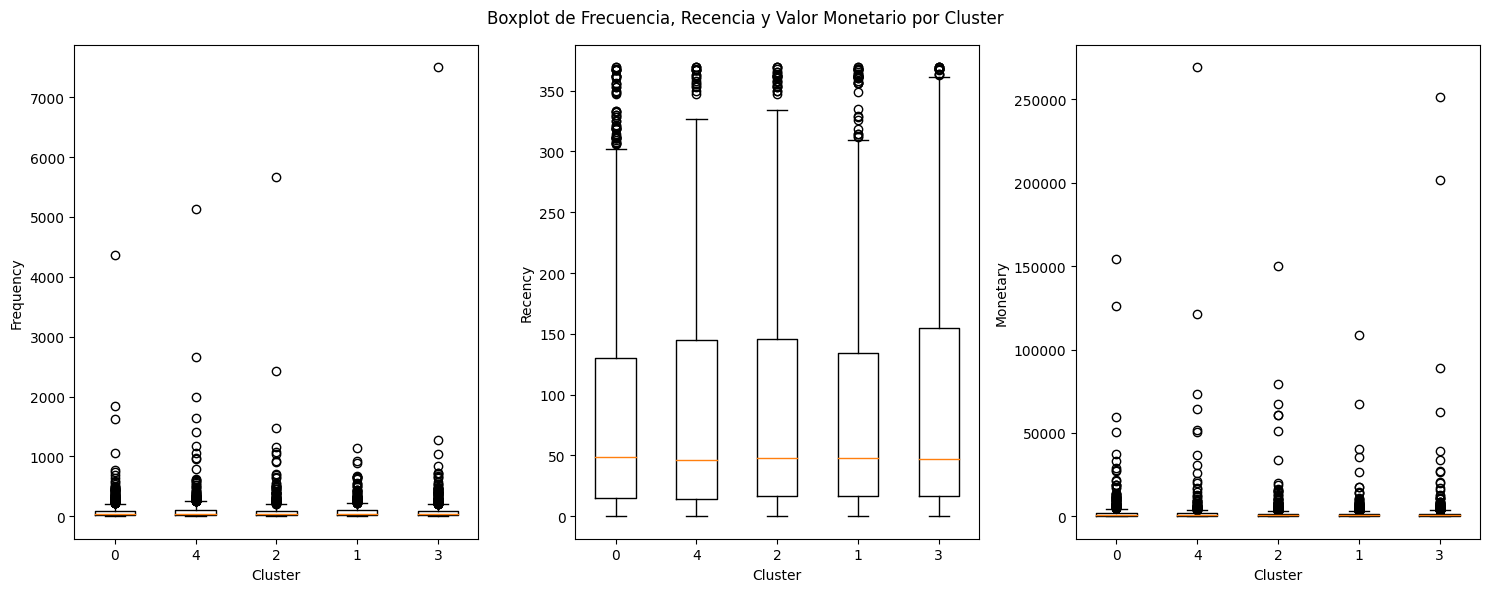

In [47]:
# Lista de los nombres de los clústeres
cluster_names = rfm_kmeans['cluster'].unique()

# Crear una figura para los boxplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Crear los boxplots para cada métrica RFM
for i, metric in enumerate(['Frequency', 'Recency', 'Monetary']):
    # Lista de los datos para cada clúster
    data = [rfm_kmeans[rfm_kmeans['cluster'] == cluster][metric] for cluster in cluster_names]

    # Graficar el boxplot
    axs[i].boxplot(data)
    axs[i].set_xticklabels(cluster_names)
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(metric.capitalize())

plt.suptitle('Boxplot de Frecuencia, Recencia y Valor Monetario por Cluster')
plt.tight_layout()
plt.show()

In [48]:
for i in range(0,k):
    print(rfm_kmeans[rfm_kmeans['cluster'] == i].describe())
    print('_______________________________________________')

         customerid     Recency    Frequency       Monetary  cluster
count    889.000000  889.000000   889.000000     889.000000    889.0
mean   12924.489314   89.833521    88.491564    2414.866064      0.0
std      346.131150  100.365455   196.833692    7877.135733      0.0
min    12346.000000    0.000000     1.000000       0.000000      0.0
25%    12619.000000   15.000000    17.000000     364.600000      0.0
50%    12919.000000   49.000000    42.000000     797.710000      0.0
75%    13226.000000  130.000000    96.000000    2099.620000      0.0
max    13527.000000  369.000000  4361.000000  154367.200000      0.0
_______________________________________________
         customerid     Recency    Frequency       Monetary  cluster
count    869.000000  869.000000   869.000000     869.000000    869.0
mean   16514.269275   89.604143    83.456847    1607.145628      1.0
std      341.719478   98.729567   116.500428    5063.729871      0.0
min    15918.000000    0.000000     1.000000       1.25

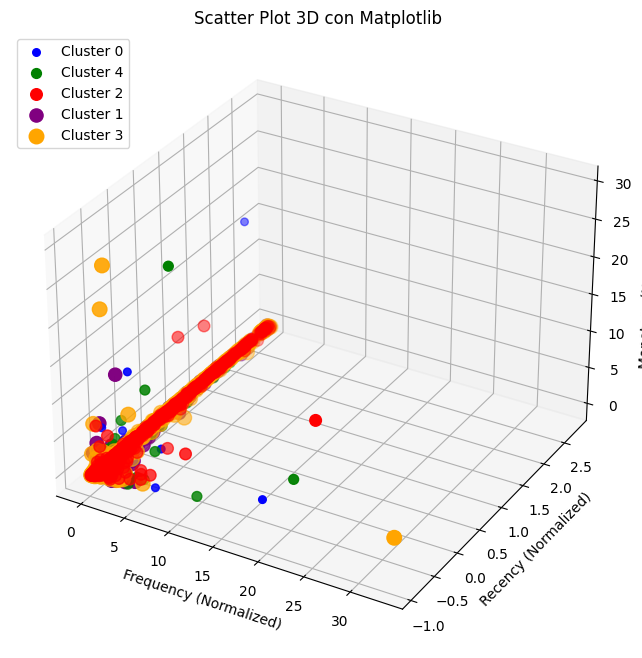

In [49]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
sizes = [30, 50, 70, 90, 110, 130, 150, 170, 190, 210]

# Graficar cada punto en el gráfico 3D
for cluster, color, size in zip(rfm_normalized['cluster'].unique(), colors, sizes):
    cluster_data = rfm_normalized[rfm_normalized['cluster'] == cluster]
    ax.scatter(cluster_data['Frequency'], cluster_data['Recency'], cluster_data['Monetary'], c=color, s=size, label=f'Cluster {cluster}')

ax.set_xlabel('Frequency (Normalized)')
ax.set_ylabel('Recency (Normalized)')
ax.set_zlabel('Monetary (Normalized)')
ax.set_title('Scatter Plot 3D con Matplotlib')
ax.legend(loc='upper left')

plt.show()

**Segmento 1 (cluster 0):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 88.35 días   | 0 días | 45.50 días | 373 días  |
| Frequency     | 100.79 veces | 1 vez  | 43 veces | 5128 veces|
| Monetary      | 2263.88 und | 2.55 und | 736.61 und | 154367.2 unds |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 88.35 días desde su última compra, lo que indica que también han comprado recientemente.
- La frecuencia de compra promedio para este segmento es de aproximadamente 100.79 veces, mostrando una mayor frecuencia de compra en comparación con los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2263.88 unidades, con una mediana de 736.61 unidades. El máximo gasto alcanza las 154367.2 unidades.

**Segmento 2 (cluster 1):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 88.83 días   | 0 días | 49 días | 373 días  |
| Frequency     | 84.57 veces  | 1 vez  | 43 veces | 5898 veces|
| Monetary      | 2029.84 und | 1.25 und | 662.27 und | 280923.02 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 88.83 días desde su última compra, lo que indica una recencia similar al Segmento 0.
- La frecuencia de compra promedio para este segmento es de aproximadamente 84.57 veces, mostrando una frecuencia ligeramente menor en comparación con los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2029.84 unidades, con una mediana de 662.27 unidades. El máximo gasto alcanza las 280923.02 unidades.

**Segmento 3 (cluster 2):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 94.29 días   | 0 días | 50.50 días | 373 días  |
| Frequency     | 91.26 veces  | 1 vez  | 38 veces | 7812 veces|
| Monetary      | 1947.93 und | 1.25 und| 590.58 und | 336942.1 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 94.29 días desde su última compra, lo que indica una recencia similar al Segmento 0 y Segmento 1.
- La frecuencia de compra promedio para este segmento es de aproximadamente 91.26 veces, mostrando una frecuencia similar a los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 1947.93 unidades, con una mediana de 590.58 unidades. El máximo gasto alcanza las 336942.1 unidades.

**Segmento 4(cluster 3):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 94.44 días   | 0 días | 47 días | 373 días  |
| Frequency     | 92.98 veces  | 1 vez  | 38 veces | 5898 veces|
| Monetary      | 2179.95 und | 11.80 und | 558.13 und | 262876.11 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 94.44 días desde su última compra, lo que indica una recencia similar a los segmentos anteriores.
- La frecuencia de compra promedio para este segmento es de aproximadamente 92.98 veces, mostrando una frecuencia similar a los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2179.95 unidades, con una mediana de 558.13 unidades. El máximo gasto alcanza las 262876.11 unidades.

**Segmento 5 (cluster 4):**

```
| Métrica       | Promedio     | Mínimo | Mediana | Máximo    |
|---------------|--------------|--------|---------|-----------|
| Recency       | 89.45 días   | 0 días | 50 días | 373 días  |
| Frequency     | 89.74 veces  | 1 vez  | 42 veces | 4459 veces|
| Monetary      | 2431.07 und | 0 und | 807.81 und | 154367.2 und |
```

*Conclusiones*
- Los clientes en este segmento han pasado, en promedio, aproximadamente 89.45 días desde su última compra, mostrando una recencia similar a los segmentos anteriores.
- La frecuencia de compra promedio para este segmento es de aproximadamente 89.74 veces, mostrando una frecuencia similar a los segmentos anteriores.
- El gasto promedio de los clientes en este segmento es de aproximadamente 2431.07 unidades, con una mediana de 807.81 unidades. El máximo gasto alcanza las 154367.2 unidades.

**Conclusiones Generales:**
- Los cinco segmentos muestran recencias similares, con clientes que han realizado compras recientemente en todos los casos.
- La frecuencia de compra promedio varía ligeramente entre los segmentos, pero en general, todos muestran una frecuencia similar de compra.
- El gasto promedio varía significativamente entre los segmentos, siendo el Segmento 4 el que muestra el mayor gasto promedio y el Segmento 1 el que muestra el menor.
